# The parallel-perpendicular decomposition 

The simplest decomposition of the flux. 

In [1]:
import xlayers
import numpy as np
import pandas as pd
# load modules 
from xlayers import finegrid, layers
from xlayers.core import layers_numpy
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from xgcm import Grid
import xarray as xr
%matplotlib inline

In [2]:
dir_zarr = '/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored_zarr/'
ds_model = xr.open_zarr(dir_zarr)

We want to do the decomposition as a function of a timescale, where the time scale will be the scale of averaging. 


In [3]:
grid = Grid(ds_model,periodic='X')

In [4]:
def divergence(flux, grid, Lcoarse):
    
    div = grid.interp(grid.diff(flux.UpCp, 'X')/Lcoarse, 'X') + \
              grid.interp(grid.diff(flux.VpCp, 'Y', boundary='extend')/Lcoarse, 'Y', boundary='extend') + \
             -grid.interp(grid.diff(flux.WpCp, 'Z', boundary='extend'), 'Z', boundary='extend')/ flux.drF
                
    return div           

In [5]:
nav = 300
#Utav = ds_model.U.coarsen(time=nav, boundary='trim').mean()
#Vtav = ds_model.V.coarsen(time=nav, boundary='trim').mean()
#Wtav = ds_model.W.coarsen(time=nav, boundary='trim').mean()
#Ttav = ds_model['T'].coarsen(time=nav, boundary='trim').mean()
ds_tav = ds_model.coarsen(time=nav, boundary='trim').mean()

In [6]:
# mean advection
div_mean_tav = (grid.interp(ds_tav.U*grid.diff(ds_tav['T'], 'X')/ds_model.dxC, 'X') + 
                grid.interp(ds_tav.V*grid.diff(ds_tav['T'], 'Y', boundary='extend')/ds_model.dyC, 'Y', boundary='extend') 
              - grid.interp(ds_tav.W*grid.diff(ds_tav['T'], 'Z', boundary='extend'), 'Z', boundary='extend')/ds_model.drF)

In [7]:
# eddy fluxes
UpTptav = ((grid.interp(ds_model.U, 'X')*ds_model['T']).coarsen(time=nav, boundary='trim').mean() 
           - grid.interp(ds_tav.U, 'X')*ds_tav['T'])

VpTptav = ((grid.interp(ds_model.V, 'Y', boundary='extend')*ds_model['T']).coarsen(time=nav, boundary='trim').mean() 
           - grid.interp(ds_tav.V, 'Y',boundary='extend')*ds_tav['T'])

WpTptav = ((grid.interp(ds_model.W, 'Z', boundary='extend')*ds_model['T']).coarsen(time=nav, boundary='trim').mean() 
           - grid.interp(ds_tav.W, 'Z',boundary='extend')*ds_tav['T'])

Tfluxtav = xr.Dataset({'UpCp':UpTptav, 'VpCp':VpTptav, 'WpCp':WpTptav})

In [8]:
Fbmod = (Tfluxtav.UpCp**2 + Tfluxtav.VpCp**2 + Tfluxtav.WpCp**2)**0.5

In [9]:
T_x = grid.interp(grid.diff(ds_tav['T'], 'X')/ ds_tav.dxC, 'X')
T_y = grid.interp(grid.diff(ds_tav['T'], 'Y', boundary='extend')/ ds_tav.dyC, 'Y', boundary='extend')
T_z = -grid.interp(grid.diff(ds_tav['T'], 'Z', boundary='extend'), 'Z', boundary='extend')/ ds_tav.drF

gradbmod = (T_x**2 + T_y**2 + T_z**2)**0.5

In [10]:
Fb_perp_mod = (Tfluxtav.UpCp*T_x + Tfluxtav.VpCp*T_y + Tfluxtav.WpCp*T_z) / gradbmod
#Fb_perp_mod = (grid.interp(Tfluxtav.UpCp,'X')*T_x + grid.interp(Tfluxtav.VpCp,'Y',boundary='extend')*T_y + 
#               grid.interp(Tfluxtav.WpCp,'Z', boundary='extend')*T_z) / gradbmod

Fb_perp_x = Fb_perp_mod*T_x / gradbmod
Fb_perp_y = Fb_perp_mod*T_y / gradbmod
Fb_perp_z = Fb_perp_mod*T_z / gradbmod

Tflux_perp_tav = xr.Dataset({'UpCp':Fb_perp_x, 'VpCp':Fb_perp_y, 'WpCp':Fb_perp_z})

In [11]:
Fb_para_x = Tfluxtav.UpCp - Tflux_perp_tav.UpCp
Fb_para_y = Tfluxtav.VpCp - Tflux_perp_tav.VpCp
Fb_para_z = Tfluxtav.WpCp - Tflux_perp_tav.WpCp

Tflux_para_tav = xr.Dataset({'UpCp':Fb_para_x, 'VpCp':Fb_para_y, 'WpCp':Fb_para_z})

In [12]:
div_eddy_tav = divergence(Tfluxtav, grid, 5e3)

In [13]:
div_perp_tav = divergence(Tflux_perp_tav, grid, 5e3)

In [14]:
div_para_tav = divergence(Tflux_para_tav, grid, 5e3)

In [17]:
div_mean_tav

<xarray.DataArray (time: 6, Z: 40, YC: 400, XC: 400)>
dask.array<sub, shape=(6, 40, 400, 400), dtype=float32, chunksize=(1, 1, 398, 398)>
Coordinates:
  * time     (time) timedelta64[ns] 61471 days 12:00:00 ... 65971 days 12:00:00
  * Z        (Z) float32 -5.0 -15.0 -25.0 -36.0 ... -2727.5 -2830.5 -2933.5
  * YC       (YC) float32 2500.0 7500.0 12500.0 ... 1992500.0 1997500.0
  * XC       (XC) float32 2500.0 7500.0 12500.0 ... 1992500.0 1997500.0
    PHrefC   (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    drF      (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>

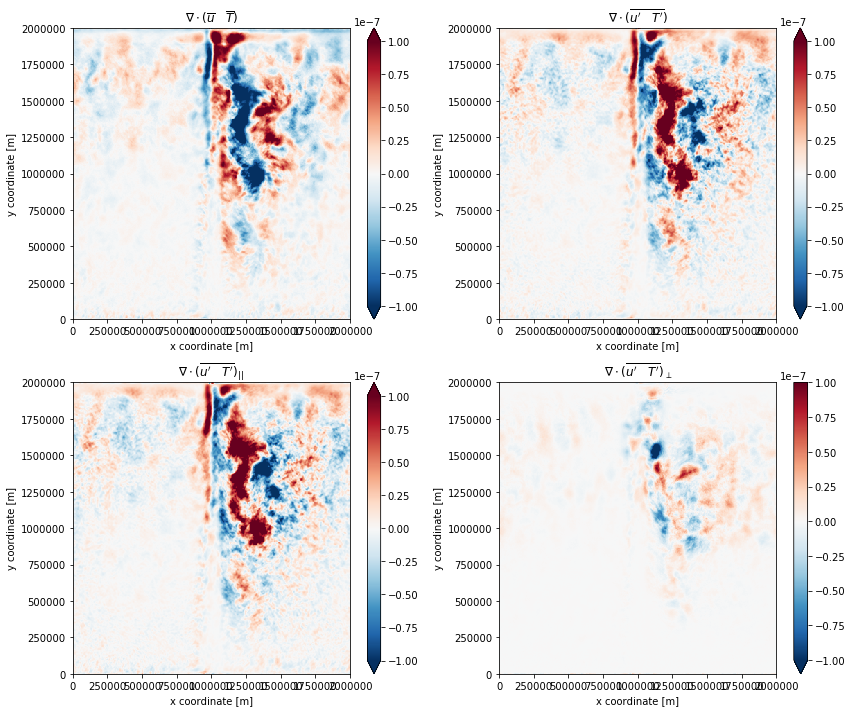

In [16]:
plt.figure(figsize=(12,10))

plt.subplot(221)
div_mean_tav.isel(time=0).sel(Z=-1000, method='nearest').plot(vmin=-1e-7, rasterized='True')
plt.title(r'$\nabla \cdot (\overline{u} \hspace{1} \overline{T})$')

plt.subplot(222)
div_eddy_tav.isel(time=0).sel(Z=-1000, method='nearest').plot(vmin=-1e-7, rasterized='True')
plt.title(r'$\nabla \cdot (\overline{u^\prime \hspace{1} T^\prime})$')

plt.subplot(223)
div_para_tav.isel(time=0).sel(Z=-1000, method='nearest').plot(vmin=-1e-7, rasterized='True')
plt.title(r'$\nabla \cdot  (\overline{u^\prime \hspace{1} T^\prime})_{||}$')

plt.subplot(224)
div_perp_tav.isel(time=0).sel(Z=-1000, method='nearest').plot(vmin=-1e-7, rasterized='True')
plt.title(r'$\nabla \cdot (\overline{u^\prime \hspace{1} T^\prime})_{\perp}$')

plt.tight_layout()

plt.savefig("inst_900days_av_fluxes_1000m.pdf")

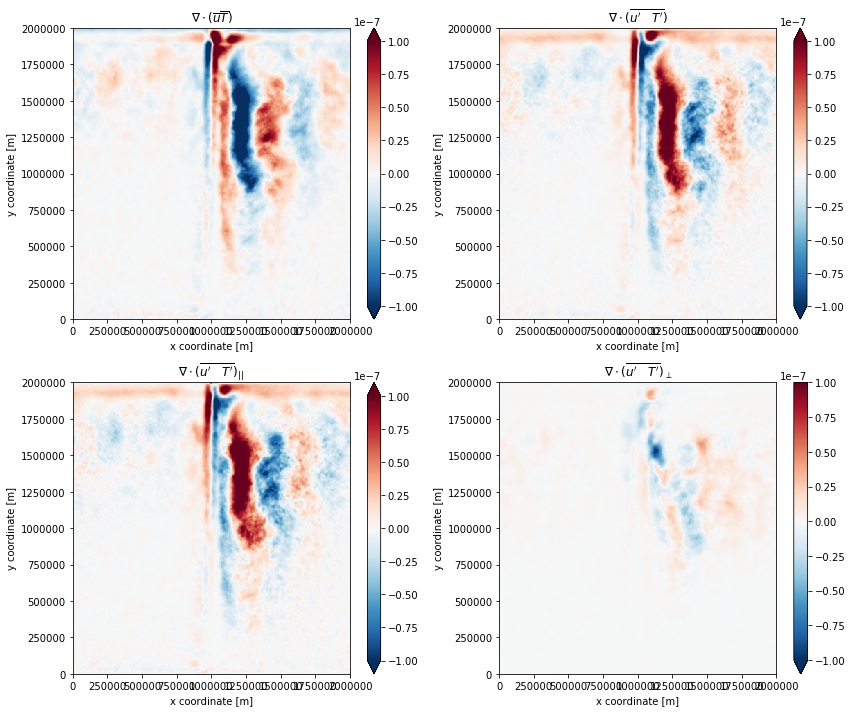

In [18]:
plt.figure(figsize=(12,10))

plt.subplot(221)
div_mean_tav.isel(time=slice(0,50)).mean('time').sel(Z=-1000, method='nearest').plot(
    vmin=-1e-7, rasterized='True')
plt.title(r'$\nabla \cdot (\overline{u} \hspace{0} \overline{T})$')

plt.subplot(222)
div_eddy_tav.isel(time=slice(0,50)).mean('time').sel(Z=-1000, method='nearest').plot(
    vmin=-1e-7, rasterized='True')
plt.title(r'$\nabla \cdot (\overline{u^\prime \hspace{1} T^\prime})$')

plt.subplot(223)
div_para_tav.isel(time=slice(0,50)).mean('time').sel(Z=-1000, method='nearest').plot(
    vmin=-1e-7, rasterized='True')
plt.title(r'$\nabla \cdot  (\overline{u^\prime \hspace{1} T^\prime})_{||}$')

plt.subplot(224)
div_perp_tav.isel(time=slice(0,50)).mean('time').sel(Z=-1000, method='nearest').plot(
    vmin=-1e-7, rasterized='True')
plt.title(r'$\nabla \cdot (\overline{u^\prime \hspace{1} T^\prime})_{\perp}$')

plt.tight_layout()
plt.savefig("mean_900days_av_50months_fluxes_1000m.pdf")

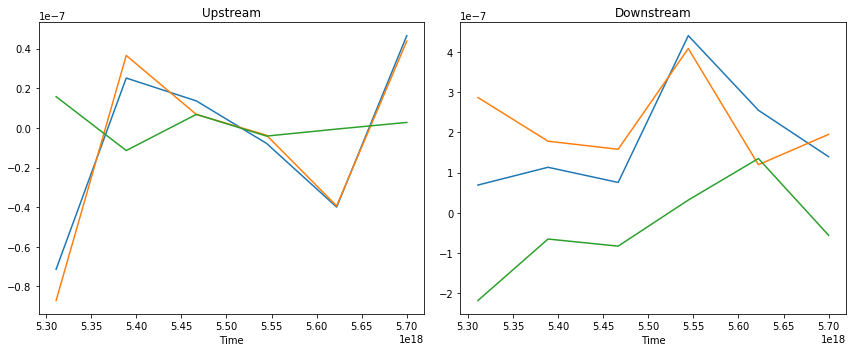

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(121)
div_eddy_tav.isel(time=slice(0,50)).sel(XC=0, YC=1000e3, Z=-500, method='nearest').plot()
div_para_tav.isel(time=slice(0,50)).sel(XC=0, YC=1000e3, Z=-500, method='nearest').plot()
div_perp_tav.isel(time=slice(0,50)).sel(XC=0, YC=1000e3, Z=-500, method='nearest').plot()
plt.title('Upstream')

plt.subplot(122)
div_eddy_tav.isel(time=slice(0,50)).sel(XC=1200e3, YC=1000e3, Z=-500, method='nearest').plot()
div_para_tav.isel(time=slice(0,50)).sel(XC=1200e3, YC=1000e3, Z=-500, method='nearest').plot()
div_perp_tav.isel(time=slice(0,50)).sel(XC=1200e3, YC=1000e3, Z=-500, method='nearest').plot()
plt.title('Downstream')

plt.tight_layout()

plt.savefig("inst_900days_timeseries_fluxes_500m.pdf")


Do a decomposition into mean and variance. 

\begin{equation}
A = B+C
\end{equation}

\begin{equation}
\overline{A} = \overline{B}+\overline{C}
\end{equation}

\begin{equation}
\overline{A'^2} = \overline{B'^2}+ \overline{C'^2} + \overline{2B'C'}
\end{equation}

In [21]:
eddy_div_up_mean = div_eddy_tav.isel(time=slice(0,30)).sel(XC=slice(0,400e3),YC=slice(800e3,1200e3)).mean(['time','XC','YC']).load()
para_div_up_mean = div_para_tav.isel(time=slice(0,30)).sel(XC=slice(0,400e3),YC=slice(800e3,1200e3)).mean(['time','XC','YC']).load()
perp_div_up_mean = div_perp_tav.isel(time=slice(0,30)).sel(XC=slice(0,400e3),YC=slice(800e3,1200e3)).mean(['time','XC','YC']).load()

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [22]:
eddy_div_up_var = div_eddy_tav.isel(time=slice(0,30)).sel(XC=slice(0,400e3),YC=slice(800e3,1200e3)).var(['time','XC','YC']).load()
para_div_up_var = div_para_tav.isel(time=slice(0,30)).sel(XC=slice(0,400e3),YC=slice(800e3,1200e3)).var(['time','XC','YC']).load()
perp_div_up_var = div_perp_tav.isel(time=slice(0,30)).sel(XC=slice(0,400e3),YC=slice(800e3,1200e3)).var(['time','XC','YC']).load()

In [26]:
eddy_div_down_mean = div_eddy_tav.isel(time=slice(0,30)).sel(XC=slice(1200e3,1600e3),YC=slice(800e3,1200e3)).mean(['time','XC','YC']).load()
para_div_down_mean = div_para_tav.isel(time=slice(0,30)).sel(XC=slice(1200e3,1600e3),YC=slice(800e3,1200e3)).mean(['time','XC','YC']).load()
perp_div_down_mean = div_perp_tav.isel(time=slice(0,30)).sel(XC=slice(1200e3,1600e3),YC=slice(800e3,1200e3)).mean(['time','XC','YC']).load()

eddy_div_down_var = div_eddy_tav.isel(time=slice(0,30)).sel(XC=slice(1200e3,1600e3),YC=slice(800e3,1200e3)).var(['time','XC','YC']).load()
para_div_down_var = div_para_tav.isel(time=slice(0,30)).sel(XC=slice(1200e3,1600e3),YC=slice(800e3,1200e3)).var(['time','XC','YC']).load()
perp_div_down_var = div_perp_tav.isel(time=slice(0,30)).sel(XC=slice(1200e3,1600e3),YC=slice(800e3,1200e3)).var(['time','XC','YC']).load()

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [28]:
Z = div_mean_tav.Z

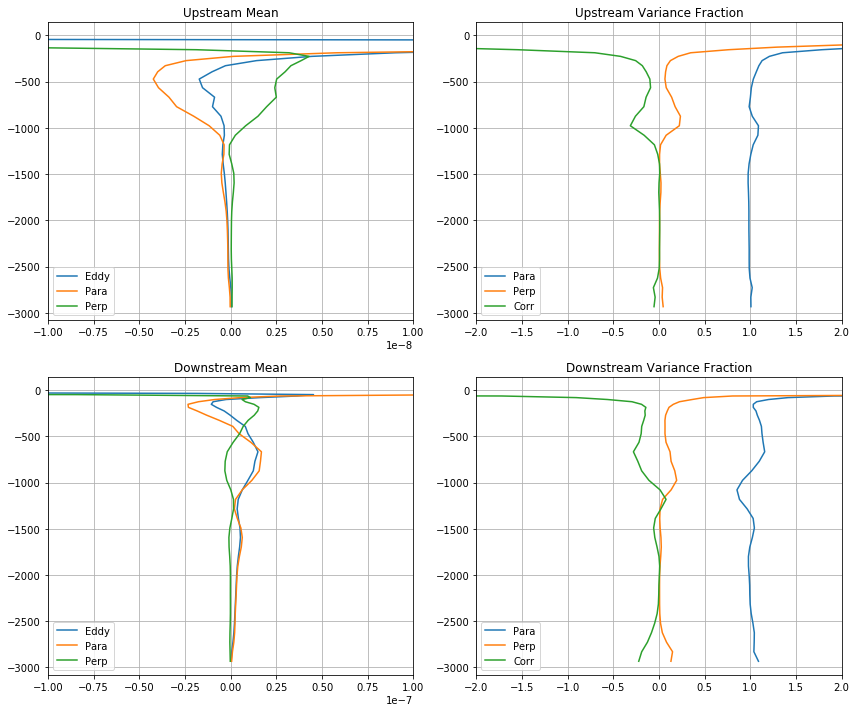

In [41]:
plt.figure(figsize=(12,10))

plt.subplot(221)
#plt.plot(mean_div_up, Z, label=r'$\nabla \cdot (\overline{u} \hspace{0} \overline{T})$')
plt.plot(eddy_div_up_mean, Z, label='Eddy')
plt.plot(para_div_up_mean, Z, label='Para')
plt.plot(perp_div_up_mean, Z, label='Perp')
#plt.xscale('symlog', linthreshx=1e-9)
plt.xlim([-1e-8, 1e-8])
plt.grid()
plt.legend()
plt.title('Upstream Mean')

plt.subplot(222)
#plt.plot(mean_div_up, Z, label=r'$\nabla \cdot (\overline{u} \hspace{0} \overline{T})$')
#plt.plot(eddy_div_up_var, Z, label='Eddy')
plt.plot(para_div_up_var/eddy_div_up_var, Z, label='Para')
plt.plot(perp_div_up_var/eddy_div_up_var, Z, label='Perp')
plt.plot((eddy_div_up_var - perp_div_up_var - para_div_up_var) /eddy_div_up_var, Z, label='Corr')
#plt.xscale('symlog', linthreshx=1e-9)
plt.xlim([-2,2])
plt.grid()
plt.legend()
plt.title('Upstream Variance Fraction')

plt.subplot(223)
#plt.plot(mean_div_up, Z, label=r'$\nabla \cdot (\overline{u} \hspace{0} \overline{T})$')
plt.plot(eddy_div_down_mean, Z, label='Eddy')
plt.plot(para_div_down_mean, Z, label='Para')
plt.plot(perp_div_down_mean, Z, label='Perp')
#plt.xscale('symlog', linthreshx=1e-9)
plt.xlim([-1e-7, 1e-7])
plt.grid()
plt.legend()
plt.title('Downstream Mean')

plt.subplot(224)
#plt.plot(mean_div_up, Z, label=r'$\nabla \cdot (\overline{u} \hspace{0} \overline{T})$')
#plt.plot(eddy_div_up_var, Z, label='Eddy')
plt.plot(para_div_down_var/eddy_div_down_var, Z, label='Para')
plt.plot(perp_div_down_var/eddy_div_down_var, Z, label='Perp')
plt.plot((eddy_div_down_var - perp_div_down_var - para_div_down_var) /eddy_div_down_var, Z, label='Corr')
#plt.xscale('symlog', linthreshx=1e-9)
plt.xlim([-2,2])
plt.grid()
plt.legend()
plt.title('Downstream Variance Fraction')

plt.tight_layout()

plt.savefig('mean_var_decomposition_avg_900days_region.pdf')

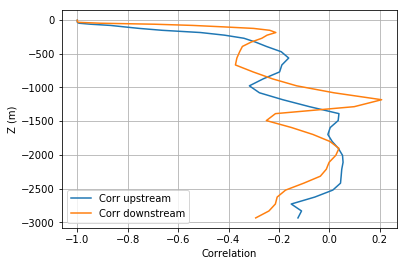

In [40]:

plt.plot((eddy_div_up_var - perp_div_up_var - para_div_up_var)/perp_div_up_var**0.5/(para_div_up_var**0.5)/2, Z, label='Corr upstream')
plt.plot((eddy_div_down_var - perp_div_down_var - para_div_down_var)/perp_div_down_var**0.5/(para_div_down_var**0.5)/2, Z, label='Corr downstream')
plt.legend()
plt.grid()
plt.xlabel('Correlation')
plt.ylabel('Z (m)')
plt.savefig('corr_decomposition_avg_900days_region.pdf')
